In [ ]:
import pandas as pd
import json
import numpy as np
from time import sleep
from sklearn.model_selection import train_test_split
from openai import OpenAI
from tqdm import tqdm
client = OpenAI(api_key=open('key.txt').read())

## Annotate data with GPT-4o

In [ ]:
# Open jsonl file

lang = "el"

# Define path to the sample, prepared in data-development-code/0-extract_sample_from_MaCoCu-Genre.ipynb

path = ""

df_entire = pd.read_json("{}".format(path), orient="records", lines=True)

print(df_entire.shape)

display(df_entire.head())

(10000, 4)


,document_id,text,genre,prediction_sample
0,macocu.el.6373650,Ομιλία Δημάρχου Πάρου για το Λιμενικό Σύστημα ...,News,no
1,macocu.el.5513105,"Βαραίνουν το κόστος οι ανατιμήσεις, ορατά τα 6...",News,no
2,macocu.el.7914732,Φόρμα αναζήτησης \n\nΜετά από 48ωρο κρεσέντο α...,News,no
3,macocu.el.12751875,Στο πλαίσιο της αναμέτρησης της Γερμανίας με τ...,News,no
4,macocu.el.183717,ΜΕ 5 ΑΘΛΗΤΕΣ ΣΤΗΝ ΣΤΙΣ ΠΡΟΕΘΝΙΚΕΣ ΟΜΑΔΕΣ OPTIM...,News,no


In [ ]:
# Take the batch of 5250 instances

df = df_entire[df_entire["prediction_sample"] == "yes"]

print(df.shape)

df.head(3)

In [ ]:
texts = df["text"].to_list()
print(texts[:2])
len(texts)

In [5]:
label_dict = {'disaster, accident and emergency incident': 0,
 'human interest': 1,
 'politics': 2,
 'education': 3,
 'crime, law and justice': 4,
 'economy, business and finance': 5,
 'conflict, war and peace': 6,
 'arts, culture, entertainment and media': 7,
 'labour': 8,
 'weather': 9,
 'religion': 10,
 'society': 11,
 'health': 12,
 'environment': 13,
 'lifestyle and leisure': 14,
 'science and technology': 15,
 'sport': 16}

reverse_dict = {x[0]:x[1] for x in enumerate(list(label_dict.keys()))}

In [6]:
f=open(f'temp_prediction_{lang}-sample-GPT4o_prompt_with_description.jsonl','wt')


In [7]:
def predict_iptc(model, prompt, df):
	responses = []
	texts = df["text"].to_list()

	for text in tqdm(texts):
		completion = client.chat.completions.create(model=model,
		response_format={ "type": "json_object"},
		messages=[
		{
			"role": "user",
			"content": prompt + f"\nText: '{text}'"}
		],
		temperature = 0)
		response=completion.choices[0].message.content

		response = response.replace("\n", "")
		response = response.replace("\t", "")

		# Convert the string into a dictionary
		response = json.loads(response)

		# Get out a label
		try:
			predicted = reverse_dict[response["topic"]]
			responses.append(predicted)
		# add a possibility of something going wrong
		except:
			predicted = "error"
			responses.append(predicted)
		
		instance={'text': text,'label': predicted}
		f.write(json.dumps(instance)+'\n')
		f.flush()

	df["IPTC_pred"] = responses

	return df

We use the prompt with the extended description.

In [8]:
label_dict_with_description_ext = {
	'disaster, accident and emergency incident - man-made or natural events resulting in injuries, death or damage, e.g., explosions, transport accidents, famine, drowning, natural disasters, emergency planning and response.': 0,
	'human interest - news about life and behavior of royalty and celebrities, news about obtaining awards, ceremonies (graduation, wedding, funeral, celebration of launching something), birthdays and anniversaries, and news about silly or stupid human errors.': 1,
	'politics - news about local, regional, national and international exercise of power, including news about election, fundamental rights, government, non-governmental organisations, political crises, non-violent international relations, public employees, government policies.': 2,
	'education - all aspects of furthering knowledge, formally or informally, including news about schools, curricula, grading, remote learning, teachers and students.': 3,
	'crime, law and justice - news about committed crime and illegal activities, the system of courts, law and law enforcement (e.g., judges, lawyers, trials, punishments of offenders).': 4,
	'economy, business and finance - news about companies, products and services, any kind of industries, national economy, international trading, banks, (crypto)currency, business and trade societies, economic trends and indicators (inflation, employment statistics, GDP, mortgages, ...), international economic institutions, utilities (electricity, heating, waste management, water supply).': 5,
	'conflict, war and peace - news about terrorism, wars, wars victims, cyber warfare, civil unrest (demonstrations, riots, rebellions), peace talks and other peace activities.': 6,
	'arts, culture, entertainment and media - news about cinema, dance, fashion, hairstyle, jewellery, festivals, literature, music, theatre, TV shows, painting, photography, woodworking, art exhibitions, libraries and museums, language, cultural heritage, news media, radio and television, social media, influencers, and disinformation.': 7,
	'labour - news about employment, employment legislation, employees and employers, commuting, parental leave, volunteering, wages, social security, labour market, retirement, unemployment, unions.': 8,
	'weather - news about weather forecasts, weather phenomena and weather warning.': 9,
	'religion - news about religions, cults, religious conflicts, relations between religion and government, churches, religious holidays and festivals, religious leaders and rituals, and religious texts.': 10,
	'society - news about social interactions (e.g., networking), demographic analyses, population census, discrimination, efforts for inclusion and equity, emigration and immigration, communities of people and minorities (LGBTQ, older people, children, indigenous people, etc.), homelessness, poverty, societal problems (addictions, bullying), ethical issues (suicide, euthanasia, sexual behavior) and social services and charity, relationships (dating, divorce, marriage), family (family planning, adoption, abortion, contraception, pregnancy, parenting).': 11,
	'health - news about diseases, injuries, mental health problems, health treatments, diets, vaccines, drugs, government health care, hospitals, medical staff, health insurance.': 12,
	'environment - news about climate change, energy saving, sustainability, pollution, population growth, natural resources, forests, mountains, bodies of water, ecosystem, animals, flowers and plants.': 13,
	'lifestyle and leisure - news about hobbies, clubs and societies, games, lottery, enthusiasm about food or drinks, car/motorcycle lovers, public holidays, leisure venues (amusement parks, cafes, bars, restaurants, etc.), exercise and fitness, outdoor recreational activities (e.g., fishing, hunting), travel and tourism, mental well-being, parties, maintaining and decorating house and garden.': 14,
	'science and technology -  news about natural sciences and social sciences, mathematics, technology and engineering, scientific institutions, scientific research, scientific publications and innovation.': 15,
	'sport - news about sports that can be executed in competitions - basketball, football, swimming, athletics, chess, dog racing, diving, golf, gymnastics, martial arts, climbing, etc.; sport achievements, sport events, sport organisation, sport venues (stadiums, gymnasiums, ...), referees, coaches, sport clubs, drug use in sport.': 16}

In [9]:
structured_prompt_label_description = f"""
			### Task
			Your task is to classify the provided text into a topic label, meaning that you need to recognize what is the topic of the text. You will be provided with a news text, delimited by single quotation marks. Always provide a label, even if you are not sure.

			### Output format
			Return a valid JSON dictionary with the following key: 'topic' and a value should be an integer which represents one of the labels according to the following dictionary: {label_dict_with_description_ext}.
			"""

In [ ]:
df = predict_iptc("gpt-4o-2024-05-13", structured_prompt_label_description, df)

df.head()

Prediction on 5000 instances cost 39.34€ and took one hour.

In [ ]:
# Save the dataset
df.to_json("/datasets/MaCoCu-5.000-sample-{}-predicted.jsonl".format(lang), orient="records", lines=True)

### Save the instances also to one dataset which will combine all the languages

In [12]:
# Add metadata
df["lang"] = lang

df.head(2)

/tmp/ipykernel_2616509/894089605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lang"] = lang


,document_id,text,genre,prediction_sample,IPTC_pred,lang
5,macocu.el.16270178,Ο Δήμος Ναυπακτίας για την επιστολή της Ομοσπο...,News,yes,politics,el
10,macocu.el.16216576,"""Λες να το δούμε κι αυτό;"", τον ρώτησε η Μάρα....",News,yes,politics,el


In [ ]:
# Open the main dataset
main_df = pd.read_json("MaCoCu-main-multilingual-predicted-dataset.jsonl", orient="records", lines=True)

print(main_df.shape)

main_df.head(2)

(15000, 6)


,document_id,genre,text,prediction_sample,IPTC_pred,lang
0,CLASSLA-web.hr.4163187,News,Osnovna škola Pećine Rijeka\n\nObavijest učeni...,yes,education,hr
1,CLASSLA-web.hr.2821678,News,U organizaciji Lige protiv raka Koprivničko-kr...,yes,health,hr


In [14]:
# Merge with the main dataset

main_df = pd.concat((main_df, df))

print(main_df.shape)

print(main_df.lang.value_counts().to_markdown())

main_df.tail(3)

(20000, 6)
| lang   |   count |
|:-------|--------:|
| hr     |    5000 |
| sl     |    5000 |
| ca     |    5000 |
| el     |    5000 |


,document_id,genre,text,prediction_sample,IPTC_pred,lang
9995,macocu.el.10523572,News,Κούβα: Πέντε θάνατοι και 816 κρούσματα κορωνοϊ...,yes,health,el
9997,macocu.el.5429726,News,"Μπάμπης Πετράκος : ""Θα φανεί στο γήπεδο ποιος ...",yes,sport,el
9999,macocu.el.15515405,News,Ανακοίνωση \n\nΠροέλευση ανακοίνωσης: \n\nΤο Π...,yes,education,el


In [ ]:
# Save the dataset
main_df.to_json("MaCoCu-main-multilingual-predicted-dataset.jsonl", orient="records", lines=True)

# Split to train and dev split

We will split each monolingual sample to 5,000 instances in the training split and 250 instances in the dev split. The split is stratified based on the label distribution.

In [ ]:
# Open the dataset
df = pd.read_json("MaCoCu-main-multilingual-predicted-dataset.jsonl", orient="records", lines=True)

print(df.shape)

df.head(2)

(21000, 6)


,document_id,genre,text,prediction_sample,IPTC_pred,lang
0,CLASSLA-web.hr.4163187,News,Osnovna škola Pećine Rijeka\n\nObavijest učeni...,yes,education,hr
1,CLASSLA-web.hr.2821678,News,U organizaciji Lige protiv raka Koprivničko-kr...,yes,health,hr


In [37]:
# Extract one language
lang = "el"

lang_df = df[df["lang"] == lang]

print(lang_df.shape)

lang_df.head(3)

(5250, 7)


,document_id,genre,text,prediction_sample,IPTC_pred,lang,split
15000,macocu.el.16270178,News,Ο Δήμος Ναυπακτίας για την επιστολή της Ομοσπο...,yes,politics,el,none
15001,macocu.el.16216576,News,"""Λες να το δούμε κι αυτό;"", τον ρώτησε η Μάρα....",yes,politics,el,none
15002,macocu.el.12003438,News,"""Τεσσάρα"" η ΑΕΛ U-20 στη Βέροια \n\nΝίκη με τε...",yes,sport,el,none


Split samples of each language into training (5000 instances) and dev (250 instances) split.

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

train, dev = train_test_split(lang_df, test_size=250, random_state=42, shuffle = True, stratify = lang_df["IPTC_pred"])

print(train.shape, dev.shape)

display(train.head(2))

display(dev.head(2))

(5000, 7) (250, 7)


,document_id,genre,text,prediction_sample,IPTC_pred,lang,split
19951,macocu.el.4314385,News,Κορίτσι μεγάλο πουλί Καθηγήτρια έστελνε γυμνές...,yes,"crime, law and justice",el,none
16554,macocu.el.11266046,News,Σημαντικά βελτιωμένο το OnePlus 10 Pro με SD 8...,yes,science and technology,el,none


,document_id,genre,text,prediction_sample,IPTC_pred,lang,split
15792,macocu.el.3582782,News,Ρεκόρ πόντων και ranking από τον Παπαγιάννη \n...,yes,sport,el,none
19671,macocu.el.7953268,News,"Πτώση Phantom: ""Είδα μια έκρηξη, φωτιά μέσα στ...",yes,"disaster, accident and emergency incident",el,none


<Axes: ylabel='label'>

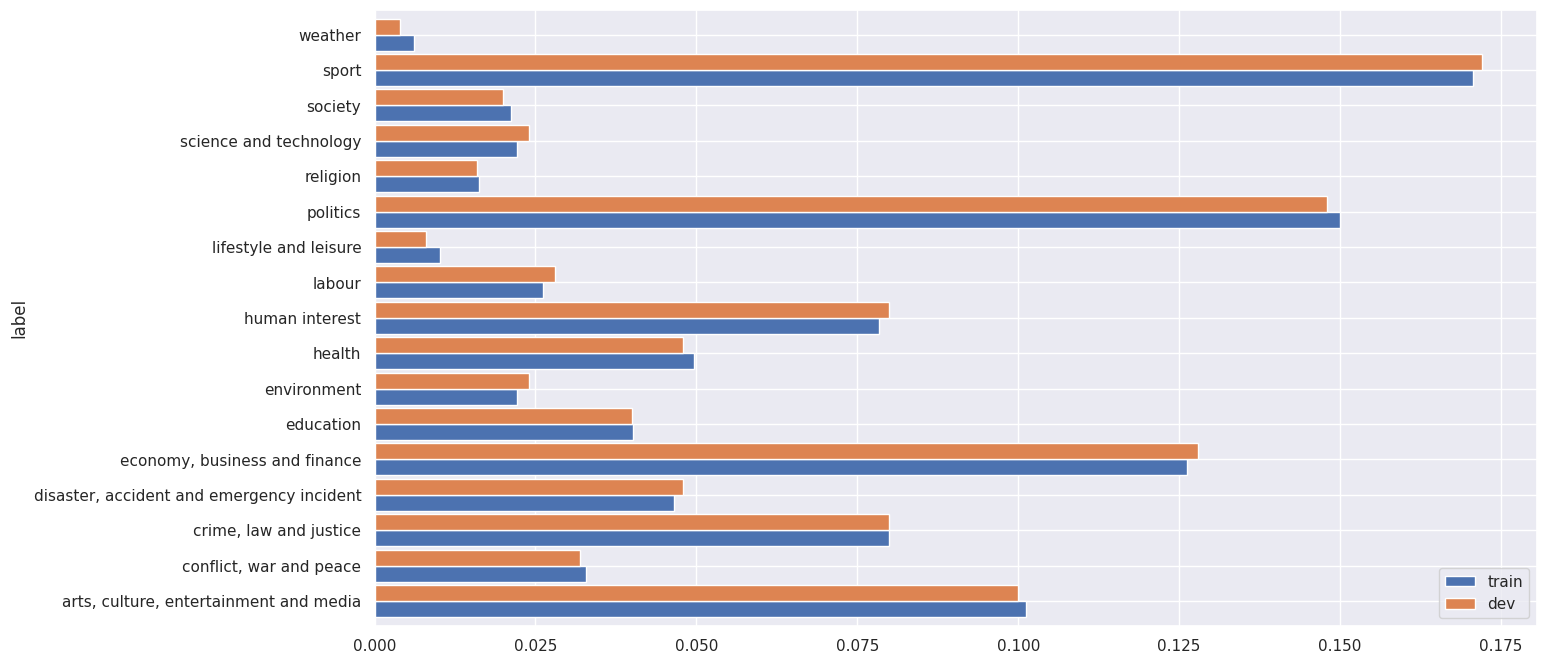

In [39]:
# Check the label distribution
label_count = pd.merge(train["IPTC_pred"].value_counts(normalize=True).rename('train').reset_index().rename(columns={"IPTC_pred": 'label'}), dev["IPTC_pred"].value_counts(normalize=True).rename('dev').reset_index().rename(columns={"IPTC_pred": 'label'}), on='label', how='outer')

# Set label as index and display the result
label_count = label_count.set_index('label')

label_count.plot(kind="barh", width=0.9)

In [40]:
# Extract ids to mark in the big sample which text is included in which split
train_ids = train["document_id"].to_list()

df["split"] = np.where((df["document_id"].isin(train_ids)), "train", df["split"])

dev_ids = dev["document_id"].to_list()

df["split"] = np.where((df["document_id"].isin(dev_ids)), "dev", df["split"])

df["split"].value_counts()

split
train    20000
dev       1000
Name: count, dtype: int64

In [41]:
df[df["lang"] == lang].head()

,document_id,genre,text,prediction_sample,IPTC_pred,lang,split
15000,macocu.el.16270178,News,Ο Δήμος Ναυπακτίας για την επιστολή της Ομοσπο...,yes,politics,el,train
15001,macocu.el.16216576,News,"""Λες να το δούμε κι αυτό;"", τον ρώτησε η Μάρα....",yes,politics,el,train
15002,macocu.el.12003438,News,"""Τεσσάρα"" η ΑΕΛ U-20 στη Βέροια \n\nΝίκη με τε...",yes,sport,el,train
15003,macocu.el.3505062,News,"Nokia: Ετοιμάζουμε smartphone, αλλά δεν βιαζόμ...",yes,"economy, business and finance",el,train
15004,macocu.el.2168176,News,"Σλούκας: ""Θέλουμε και την τύχη με το μέρος μας...",yes,sport,el,train


In [42]:
df.groupby("lang").split.value_counts()

lang  split
ca    train    5000
      dev       250
el    train    5000
      dev       250
hr    train    5000
      dev       250
sl    train    5000
      dev       250
Name: count, dtype: int64

In [ ]:
# Save the dataset
df.to_json("MaCoCu-main-multilingual-predicted-dataset.jsonl", orient="records", lines=True)

# Split to smaller samples

In [ ]:
import pandas as pd
import numpy as np

We will split the existing 20.000 training instances to smaller samples to experiment with the impact of dataset size:
- 15.000: 3.750 per lang
- 10.000: 2.500 per lang
- 5.000: 1250 per lang
- 2.500: 625 per lang
- 1.000: 250 per lang



We will split each monolingual sample (5,000 instances) to smaller size and then merge them to get the final sample that is balanced across languages. The split is stratified based on the label distribution.

We keep the dev split the same.

In [3]:
# Open the dataset
df = pd.read_json("MaCoCu-main-multilingual-predicted-dataset.jsonl", orient="records", lines=True)

print(df.shape)

df.head(2)

(21000, 24)


,document_id,genre,text,prediction_sample,IPTC_pred,lang,split,20k_sample,15k_sample,10k_sample,...,15k_sample_2,15k_sample_3,10k_sample_2,10k_sample_3,5k_sample_2,5k_sample_3,2.5k_sample_2,2.5k_sample_3,1k_sample_2,1k_sample_3
0,CLASSLA-web.hr.4163187,News,Osnovna škola Pećine Rijeka\n\nObavijest učeni...,yes,education,hr,dev,no,no,no,...,no,no,no,no,no,no,no,no,no,no
1,CLASSLA-web.hr.2821678,News,U organizaciji Lige protiv raka Koprivničko-kr...,yes,health,hr,train,yes,no,no,...,yes,yes,yes,yes,yes,yes,yes,no,no,no


In [4]:
import numpy as np
df["20k_sample"] = np.where(df["split"] == "train", "yes", "no")

df.head(5)

,document_id,genre,text,prediction_sample,IPTC_pred,lang,split,20k_sample
0,CLASSLA-web.hr.4163187,News,Osnovna škola Pećine Rijeka\n\nObavijest učeni...,yes,education,hr,dev,no
1,CLASSLA-web.hr.2821678,News,U organizaciji Lige protiv raka Koprivničko-kr...,yes,health,hr,train,yes
2,CLASSLA-web.hr.2508108,News,[VIDEO] Rimac: Ova pobjeda u Beogradu znači pu...,yes,sport,hr,train,yes
3,CLASSLA-web.hr.4605247,News,Učenici prvih razreda naših škola iz Šarengrad...,yes,education,hr,train,yes
4,CLASSLA-web.hr.2602058,News,Poziv članovima Sindikata hrvatskih željezniča...,yes,labour,hr,train,yes


In [8]:
# Add columns for other splits
df["15k_sample"] = "no"
df["10k_sample"] = "no"
df["5k_sample"] = "no"
df["2.5k_sample"] = "no"
df["1k_sample"] = "no"

df.head(3)

,document_id,genre,text,prediction_sample,IPTC_pred,lang,split,20k_sample,15k_sample,10k_sample,5k_sample,2.5k_sample,1k_sample
0,CLASSLA-web.hr.4163187,News,Osnovna škola Pećine Rijeka\n\nObavijest učeni...,yes,education,hr,dev,no,no,no,no,no,no
1,CLASSLA-web.hr.2821678,News,U organizaciji Lige protiv raka Koprivničko-kr...,yes,health,hr,train,yes,no,no,no,no,no
2,CLASSLA-web.hr.2508108,News,[VIDEO] Rimac: Ova pobjeda u Beogradu znači pu...,yes,sport,hr,train,yes,no,no,no,no,no


In [6]:
# Start with the 20k train split

train_df = df[df["split"] == "train"]
print(train_df.shape)

train_df.head(2)

(20000, 34)


,document_id,genre,text,prediction_sample,IPTC_pred,lang,split,20k_sample,15k_sample,10k_sample,...,15k_sample_4,15k_sample_5,10k_sample_4,10k_sample_5,5k_sample_4,5k_sample_5,2.5k_sample_4,2.5k_sample_5,1k_sample_4,1k_sample_5
1,CLASSLA-web.hr.2821678,News,U organizaciji Lige protiv raka Koprivničko-kr...,yes,health,hr,train,yes,no,no,...,no,no,no,no,no,no,no,no,no,no
2,CLASSLA-web.hr.2508108,News,[VIDEO] Rimac: Ova pobjeda u Beogradu znači pu...,yes,sport,hr,train,yes,no,no,...,no,no,no,no,no,no,no,no,no,no


In [7]:
def split_to_smaller_sample(lang, df, split_size, split_name, main_df, random_state):
	import numpy as np
	from sklearn.model_selection import train_test_split
	
	# Extract one language
	print(lang)
	lang_df = df[df["lang"] == lang]

	print(lang_df.shape)

	#display(lang_df.head(2))

	# Split into smaller size
	# In the first version of the splits, random_state was 42
	rest, df_split = train_test_split(lang_df, test_size=split_size, random_state=random_state, shuffle = True, stratify = lang_df["IPTC_pred"])

	print("Dataset split to the following two sizes:")
	print(df_split.shape, rest.shape)

	#print("Sample:")
	#display(df_split.head(2))

	#print("Rest:")
	#display(rest.head(2))

	# Check the label distribution
	label_count = pd.merge(rest["IPTC_pred"].value_counts(normalize=True).rename('rest').reset_index().rename(columns={"IPTC_pred": 'label'}), df_split["IPTC_pred"].value_counts(normalize=True).rename('sample').reset_index().rename(columns={"IPTC_pred": 'label'}), on='label', how='outer')

	# Set label as index and display the result
	label_count = label_count.set_index('label')

	#label_count.plot(kind="barh", width=0.9)

	# Extract ids to mark in the big sample which text is included in which split
	split_ids = df_split["document_id"].to_list()

	main_df[f"{split_name}"] = np.where((main_df["document_id"].isin(split_ids)), "yes", main_df[f"{split_name}"])

	print(main_df[f"{split_name}"].value_counts().to_markdown())

	print(main_df.groupby("lang")[f"{split_name}"].value_counts().to_markdown())

	return main_df

In [ ]:
# Example of creating a split based on a certain size - do this for each size. To create various samples of the same size, change the random state number 
random_state = 73

for lang in ["hr", "sl", "ca", "el"]:
	df = split_to_smaller_sample(lang, train_df, 2500, '10k_sample', df, random_state)

In [23]:
# Save the dataset
df.to_json("MaCoCu-main-multilingual-predicted-dataset.jsonl", orient="records", lines=True)

- 15.000: 3.750 per lang
- 10.000: 2.500 per lang
- 5.000: 1250 per lang
- 2.500: 625 per lang
- 1.000: 250 per lang